In [3]:
import pickle
from importlib import reload  

import json
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression, link_classification
from stellargraph.data import EdgeSplitter
from tensorflow.keras import Model, optimizers, losses, metrics, layers
from het_data import HetGraph
import model
import stellargraph as sg

from PIL import Image

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline

In [180]:
reload(dataset)
reload(model)

import het_data
reload(het_data)

<module 'het_data' from '/Users/kamilwyszynski/Desktop/University/Final Year Project/implementation/het_data.py'>

In [4]:
# Creating a new dataset
num_img = 10000

hg = HetGraph()
hg.load_viz_wiz(num_img, fully_connected=False, image_threshold=0.765, word_threshold=0.535)

data = hg.get_stellar_graph()

pickle.dump(data, open(f'res/graphs/{num_img}_img_stellar_not_fc_mc.hg', 'wb'))

wn wood table Red and blue drink coaster on top of a wooden surface. The top to a K-Cup decaf Colombian coffee, sitting on a wooden desk. A used Keurig coffee pod on a wooden desk.
Added 9942 images.
Image caption:  a computer screen showing some customization and install options Customization windows are being shown on a computer screen. A computer screen that shows something being installed. Quality issues are too severe to recognize visual content. SHOW ON PRINTED WORDS ON MONITOR SHOWED BACK AND NEXT
Added 9943 images.
Image caption:  A close up of a horse's face in a stable. A horses face that is very close to the camera lens. A horse brings it's face near the camera in the barn. Appears to be an animal called horse inside a barn The up close face of a horse standing in a brown barn.
Added 9944 images.
Image caption:  Beverage in an unopened aluminum can showing Nutrition Facts. a black tin of a drink showing Nutritional facts Can of soda sitting on a wood end table. BLACK CAN OF 

In [144]:
# load graph
data = pickle.load(open('res/graphs/1000_img_stellar_not_fc_mc.hg', 'rb'))

In [5]:
print(data.info())

StellarGraph: Undirected multigraph
 Nodes: 21344, Edges: 406457

 Node types:
  word: [11344]
    Features: float32 vector, length 300
    Edge types: word-image2word->image, word-word2word->word
  image: [10000]
    Features: float32 vector, length 512
    Edge types: image-image2image->image, image-image2word->word

 Edge types:
    image-image2word->word: [221612]
        Weights: all 1 (default)
        Features: none
    image-image2image->image: [156432]
        Weights: range=[0.765, 1], mean=0.789674, std=0.0335917
        Features: none
    word-word2word->word: [28413]
        Weights: range=[0.535003, 0.976326], mean=0.621736, std=0.0841548
        Features: none


#### Node similarity testing

# Training

In [172]:
edges_train, edges_test, labels_train, labels_test, g_train, g_test = model.split_graph(data, p_test=0.2, p_train=0.999)

Network has 21967 edges of type image2word
Network has 21967 edges of type image2word
** Sampled 4393 positive and 4393 negative edges. **
Network has 17574 edges of type image2word
Network has 17574 edges of type image2word
** Sampled 17556 positive and 17556 negative edges. **


In [150]:
def train(data, edges_train, edges_test, labels_train, labels_test, num_samples=[15,4], dropout=0.0):
    generator, train_gen, test_gen = model.get_hinsage_generators(data, edges_train, edges_test, labels_train, 
                                                                  labels_test, batch_size=50, num_samples=num_samples, 
                                                                  shuffle=True, head_node_types=['image', 'word'])

    hetmodel = model.get_hinsage_model(generator, train_gen, test_gen, num_samples=num_samples, hinsage_layer_sizes=[64, 64], 
                                   bias=True, dropout=0.0, lr=1e-3, edge_embedding_method='l1', output_act='sigmoid')

    model.perform(hetmodel, generator, train_gen, test_gen, labels_test, num_workers=4, epochs=35, verbose=1, shuffle=False)

In [177]:
num_samples=[15,4]
generator_train, generator_test, train_gen, test_gen = model.get_hinsage_generators(
    g_train, 
    g_test, 
    edges_train, 
    edges_test, 
    labels_train, 
    labels_test, 
    batch_size=50, 
    num_samples=num_samples, 
    shuffle=True,
    head_node_types=['image', 'word']
)

In [178]:
hetmodel = model.get_hinsage_model(
    generator_train, 
    train_gen, 
    test_gen, 
    num_samples=num_samples, 
    hinsage_layer_sizes=[64, 64], 
    bias=True, 
    dropout=0.0, 
    lr=1e-3, 
    edge_embedding_method='l1', 
    output_act='sigmoid'
)

link_classification: using 'l1' method to combine node embeddings into edge embeddings


176/176 [==============================] - 25s 128ms/step - loss: 0.6924 - binary_accuracy: 0.5000 - recall_m: 0.4213 - precision_m: 0.8429 - f1_m: 0.5597
Untrained model's Test Evaluation:
	loss: 0.6937
	binary_accuracy: 0.5038
	recall_m: 0.2514
	precision_m: 0.4995
	f1_m: 0.3331
Epoch 1/10
703/703 [==============================] - 141s 195ms/step - loss: 0.5386 - binary_accuracy: 0.7411 - recall_m: 0.6828 - precision_m: 0.7856 - f1_m: 0.7215 - val_loss: 0.8546 - val_binary_accuracy: 0.5096 - val_recall_m: 0.4618 - val_precision_m: 0.4992 - val_f1_m: 0.4795
Epoch 2/10
703/703 [==============================] - 137s 195ms/step - loss: 0.4779 - binary_accuracy: 0.7799 - recall_m: 0.6919 - precision_m: 0.8392 - f1_m: 0.7541 - val_loss: 0.8525 - val_binary_accuracy: 0.5275 - val_recall_m: 0.4560 - val_precision_m: 0.4992 - val_f1_m: 0.4763
Epoch 3/10
703/703 [==============================] - 133s 188ms/step - loss: 0.4538 - binary_accuracy: 0.7944 - recall_m: 0.7220 - precision_m: 0.843

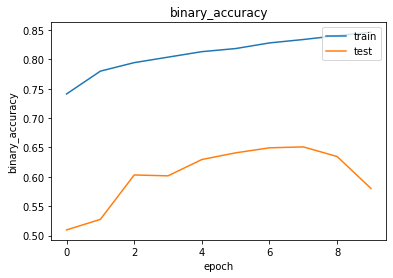

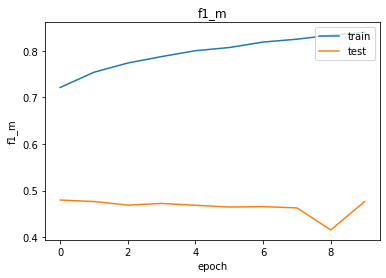

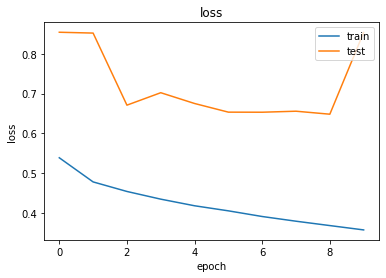

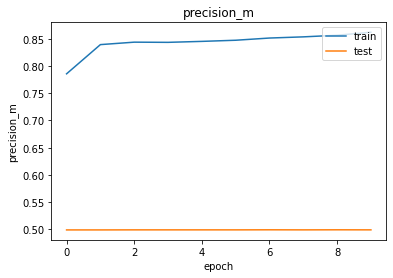

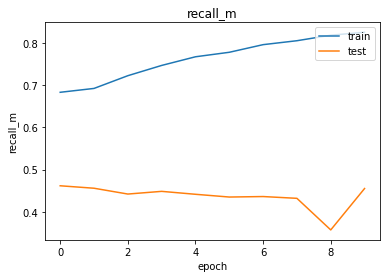

176/176 [==============================] - 22s 120ms/step - loss: 0.8563 - binary_accuracy: 0.5799 - recall_m: 0.4560 - precision_m: 0.4993 - f1_m: 0.4764
Test Evaluation:
	loss: 0.8563
	binary_accuracy: 0.5799
	recall_m: 0.4560
	precision_m: 0.4993
	f1_m: 0.4764
Mean Baseline Test set metrics:
	root_mean_square_error =  0.5
	mean_absolute_error =  0.5

Model Test set metrics:
	root_mean_square_error =  0.5389681480945351
	mean_absolute_error =  0.4155384519703698


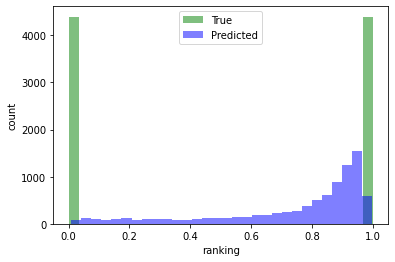

In [181]:
model.perform(hetmodel, generator_train, train_gen, test_gen, labels_test, num_workers=4, epochs=10, verbose=1, shuffle=False)

# Model Evaluation

In [98]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
import networkx as nx
import dataset

reload(dataset)

<module 'dataset' from '/Users/kamilwyszynski/Desktop/University/Final Year Project/implementation/dataset.py'>

In [99]:
vw = dataset.VizWiz()

In [17]:
test_pred = hetmodel.predict(test_gen)
test_pred

array([[8.9489043e-01],
       [9.5107865e-01],
       [9.9301291e-01],
       ...,
       [8.1690887e-05],
       [3.1122416e-02],
       [1.5401840e-04]], dtype=float32)

In [20]:
test_pred.squeeze()

array([8.9489043e-01, 9.5107865e-01, 9.9301291e-01, ..., 8.1690887e-05,
       3.1122416e-02, 1.5401840e-04], dtype=float32)

In [19]:
labels_test

array([1, 1, 1, ..., 0, 0, 0])

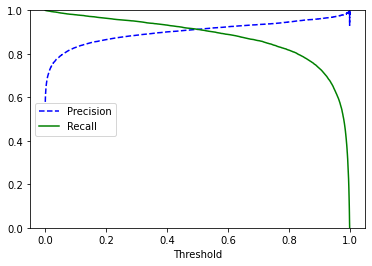

In [23]:
precisions, recalls, thresholds = precision_recall_curve(labels_test, test_pred.squeeze())

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim(0, 1)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

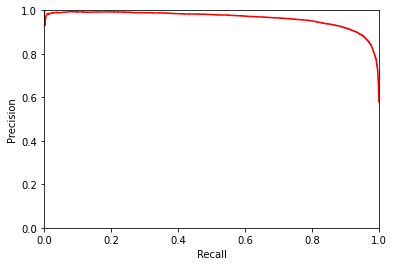

In [33]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'r-')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim(0, 1)
    plt.ylim(0, 1)

plot_precision_vs_recall(precisions, recalls)

In [25]:
pred = np.where(test_pred.squeeze() > 0.5, 1, 0)

In [36]:
conf_mat = confusion_matrix(labels_test, pred)
conf_mat

array([[10731,  1029],
       [ 1026, 10734]])

In [59]:
pred = np.where(test_pred.squeeze() > 0.5, 1, 0)

In [53]:
pred = np.where(test_pred.squeeze() > 0.92, 1, 0)

p = precision_score(labels_test, pred)
r = recall_score(labels_test, pred)
print(f'Precision: {round(p*100,2)}%\nRecall: {round(r*100,2)}%')

# We can also calculate the F1 score
# That is, a harmonic mean of precision and recall.

# This is a measure that get's higher the more similar precision and recall values are
f1 = f1_score(labels_test, pred)

print(f'F1 score: {round(f1*100,2)}%')

Precision: 96.47%
Recall: 70.35%
F1 score: 81.36%


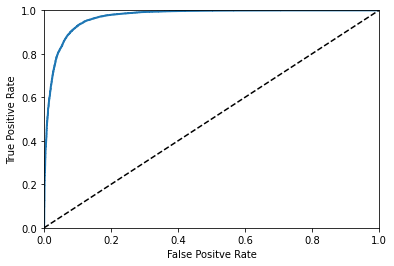

In [34]:
fpr, tpr, thresholds = roc_curve(labels_test, test_pred.squeeze())

def plot_roc(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.xlabel('False Positve Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])

plot_roc(fpr, tpr)

In [19]:
data.nodes(node_type='image')

array(['VizWiz_train_00000000.jpg', 'VizWiz_train_00000001.jpg',
       'VizWiz_train_00000003.jpg', ..., 'VizWiz_train_00003432.jpg',
       'VizWiz_train_00003433.jpg', 'VizWiz_train_00003434.jpg'],
      dtype=object)

In [54]:
edges_test

array([['VizWiz_train_00007891.jpg', 'skyscrapers'],
       ['VizWiz_train_00005694.jpg', 'covered'],
       ['VizWiz_train_00010504.jpg', 'white'],
       ...,
       ['VizWiz_train_00011039.jpg', "cap'n"],
       ['VizWiz_train_00003745.jpg', 'playing'],
       ['VizWiz_train_00000356.jpg', 'skein']], dtype=object)

In [69]:
np.concatenate((edges_test, np.expand_dims(labels_test, 1), np.expand_dims(pred, 1)), axis=1)[:5]

array([['VizWiz_train_00007891.jpg', 'skyscrapers', 1, 1],
       ['VizWiz_train_00005694.jpg', 'covered', 1, 1],
       ['VizWiz_train_00010504.jpg', 'white', 1, 1],
       ['VizWiz_train_00008333.jpg', 'contains', 1, 1],
       ['VizWiz_train_00008004.jpg', 'right', 1, 1]], dtype=object)

In [108]:
vw.get_caption('VizWiz_train_00000001.jpg')

'A green and white plastic condiment bottle containing Basil leaves.'

skyscrapers 1 1
covered 1 1
white 1 1
contains 1 1
right 1 1
wearing 1 1
table 1 1
surface 1 1
knob 1 1
computer 1 1


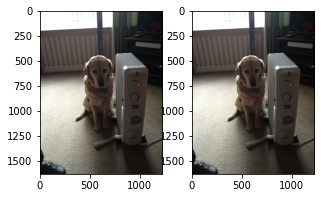

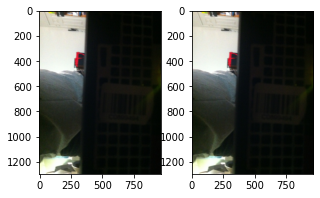

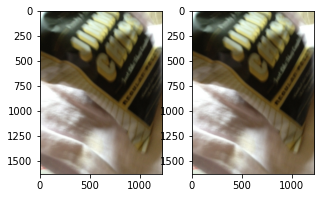

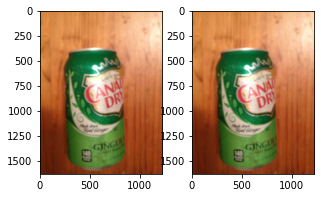

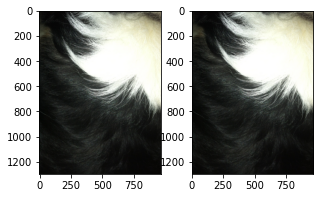

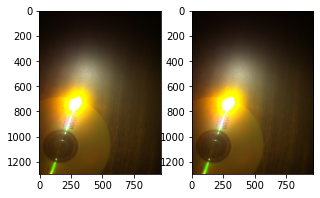

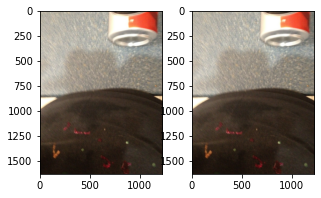

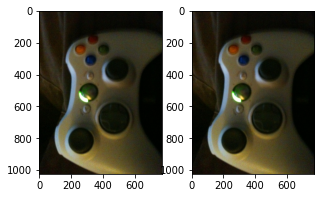

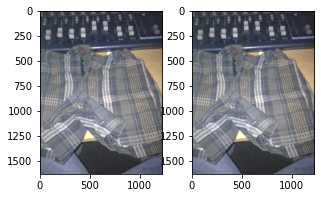

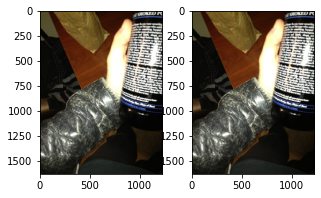

In [77]:
for i in np.concatenate((edges_test, np.expand_dims(labels_test, 1), np.expand_dims(pred, 1)), axis=1)[:10]:
    show_images(i[0], i[0])
    print(i[1], i[2], i[3])

In [63]:
labels_test.unsqueeze()

AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

In [65]:
np.expand_dims(labels_test, 1)

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [6]:
data.in_node_arrays('VizWiz_train_00007891.jpg')

array(['sitting', 'lab', 'dog', 'golden', 'floor', 'beside', 'retriever',
       'VizWiz_train_00002146.jpg', 'VizWiz_train_00002215.jpg',
       'electric', 'portable', 'next', 'white', 'heater', 'turned', 'tan',
       'VizWiz_train_00005523.jpg', 'VizWiz_train_00001370.jpg'],
      dtype=object)

In [90]:
'VizWiz_train_00007891.jpg'[13:-4]

'00007891'

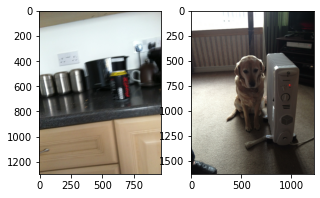

In [105]:
show_images('VizWiz_train_00000001.jpg', 'VizWiz_train_00007891.jpg')

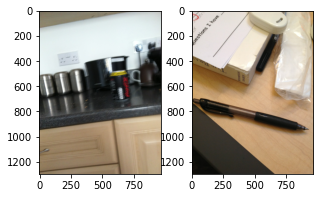

In [110]:
show_images('VizWiz_train_00000001.jpg', 'VizWiz_train_00010000.jpg')

In [123]:
for i in range(5):
    print(vw.annotations['annotations'][10000*5+i])

{'caption': 'Nicely taken the picture and focus point of the object is nice.', 'image_id': 10000, 'is_precanned': False, 'is_rejected': True, 'id': 50000, 'text_detected': True}
{'caption': 'A textbook, papers, a black ink pen, and other unidentifiable items sitting on a wooden table.', 'image_id': 10000, 'is_precanned': False, 'is_rejected': False, 'id': 50001, 'text_detected': True}
{'caption': 'A desk has a pen, a white book and several papers on it.', 'image_id': 10000, 'is_precanned': False, 'is_rejected': False, 'id': 50002, 'text_detected': True}
{'caption': 'A black ink pen on a desk with some papers and a book.', 'image_id': 10000, 'is_precanned': False, 'is_rejected': False, 'id': 50003, 'text_detected': True}
{'caption': 'A black clicker pen that has a rubber grip on it', 'image_id': 10000, 'is_precanned': False, 'is_rejected': False, 'id': 50004, 'text_detected': False}


In [130]:
reload(dataset)
vw = dataset.VizWiz()

In [137]:
vw.__next__()[1].split()

['A',
 'person',
 'uses',
 'a',
 'pair',
 'of',
 'brown',
 'hiking',
 'boots.',
 'Two',
 'boot',
 'encased',
 'feet',
 'and',
 'blue',
 'jean',
 'clad',
 'legs',
 'are',
 'standing',
 'on',
 'an',
 'off-white',
 'floor.',
 'Someone',
 'wearing',
 'brown',
 'work',
 'boots',
 'has',
 'taken',
 'a',
 'picture',
 'of',
 'a',
 'white',
 'floor.',
 'Quality',
 'issues',
 'are',
 'too',
 'severe',
 'to',
 'recognize',
 'visual',
 'content.',
 'A',
 "person's",
 'feet',
 'wearing',
 'brown',
 'shoes',
 'on',
 'a',
 'white',
 'floor.']

In [ ]:
def show_images(img1, img2):

    # figure size in inches optional
    rcParams['figure.figsize'] = 5 ,3

    # read images
    img_A = mpimg.imread(os.path.join('res/vizwiz/train', img1))
    img_B = mpimg.imread(os.path.join('res/vizwiz/train', img2))

    # display images
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(img_A);
    ax[1].imshow(img_B);

In [163]:
import tensorflow as tf
c = tf.constant([[0.3, 0.5, 0.8]])
c = tf.where(c > 0.5, 1, 0)